In [406]:
FEATURE_TYPES = ['ACT_SITE',
                 'BINDING',
                 'CA_BIND',
                 'CHAIN',
                 'COILED',
                 'COMPBIAS',
                 'CONFLICT',
                 'CROSSLNK',
                 'DISULFID',
                 'DNA_BIND',
                 'DOMAIN',
                 'INIT_MET',
                 'INTRAMEM',
                 'LIPID',
                 'METAL',
                 'MOD_RES',
                 'MOTIF',
                 'MUTAGEN',
                 'NON_STD',
                 'NP_BIND',
                 'PEPTIDE',
                 'PROPEP',
                 'REGION',
                 'REPEAT',
                 'SIGNAL',
                 'SITE',
                 'TOPO_DOM',
                 'TRANSMEM',
                 'TURN',
                 'VARIANT',
                 'STRAND',
                 'VAR_SEQ',
                 'HELIX',
                 'ZN_FING',
                 'POLYPROLINES']

In [397]:
import re
from Bio import SwissProt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [390]:
def find_polyproline_motifs(sequence):
    """Returns a list of indices where polyproline motifs are located"""
    matches = []
    for match in re.finditer(r"PP+", sequence):
        matches += [*range(*match.span())]
    return matches

def get_pp_motif_positions(sequence):
    """Returns a list of polyproline motifs starting positions"""
    matches = []
    idx = 0
    while idx != len(sequence):
        match = re.match(r"PP+", sequence[idx:])
        if match:
            matches.append(idx)
            idx += match.end()
        else:
            idx += 1
    return matches

def polyproline_overlap_mask(feature_map, feature):
    """Returns a bitmask where 1 represent overlap between polyproline
    motif and given 'feature'"""
    overlap = data[feature] + data.POLYPROLINES
    return overlap == data[feature].max() + data.POLYPROLINES.max()

def count_bitmask_seqs(pp_mask):
    """Returns number of contiguous sequences using bitmap"""
    count = 0
    status = False
    for idx, i in enumerate(pp_mask):
        if i:
            status = True
        if (not i and status) or (i and idx == len(pp_mask) - 1):
            count += 1
            status = False
    return count

def get_rel_pp_position(record, target_feature):
    """Returns relative positions of polyproline motifs in given 'feature' if there are any"""
    motif_feature_positions = []
    motif_position = find_polyproline_motifs(record.sequence)
    for feature in record.features:
        if feature.type == target_feature:
            feature_location = {*feature.location}
            overlap = set(motif_position) & feature_location
            if overlap:
                motif_feature_positions.append((min(overlap) - feature.location.start) / len(feature_location))
    return motif_feature_positions

In [410]:
def proline_feature_map_generator(file, thresh_coverage=0.8):
    """Parses swissprot proteome file. Only sequences with coverage of 3d structures
    greater than 'thresh_coverage' are used.
    Generator yields feature_map which is collection (DataFrame) of bitmasks
    for every feature and record itself"""
    for record in SwissProt.parse(file):
        try:
            motif_map = find_polyproline_motifs(record.sequence)
            if motif_map and get_pdb_coverage(record) > thresh_coverage:
                feature_map = pd.DataFrame(np.zeros((len(record.sequence), len(FEATURE_TYPES))), columns=FEATURE_TYPES, dtype="uint8")
                for feature in record.features:
                    feature_map.loc[[*feature.location], feature.type] = FEATURE_TYPES.index(feature.type) / len(FEATURE_TYPES)
                feature_map.loc[motif_map, "POLYPROLINES"] = 1
                yield feature_map, record
        except TypeError:
            pass
        
def get_pdb_coverage(record):
    """Calculates coverage of sequence with 3d structures. Possible 
    values are in the interval [0, +inf)"""
    pdb_refs = filter(lambda x: "PDB" == x[0], record.cross_references)
    structure_coverages_str = map(lambda x: x[-1].split("=")[-1].split("-"), pdb_refs)
    structure_coverages_int = map(lambda x: int(x[1]) - int(x[0]), structure_coverages_str)
    return sum(structure_coverages_int) / record.sequence_length

## Interactive view

In [516]:
gen = proline_feature_map_generator("uniprot-proteome_UP000000625.txt")

MSDVAETLDPLRLPLQGERLIEASAGTGKTFTIAALYLRLLLGLGGSAAFPRPLTVEELLVVTFTEAATAELRGRIRSNIHELRIACLRETTDNPLYERLLEEIDDKAQAAQWLLLAERQMDEAAVFTIHGFCQRMLNLNAFESGMLFEQQLIEDESLLRYQACADFWRRHCYPLPREIAQVVFETWKGPQALLRDINRYLQGEAPVIKAPPPDDETLASRHAQIVARIDTVKQQWRDAVGELDALIESSGIDRRKFNRSNQAKWIDKISAWAEEETNSYQLPESLEKFSQRFLEDRTKAGGETPRHPLFEAIDQLLAEPLSIRDLVITRALAEIRETVAREKRRRGELGFDDMLSRLDSALRSESGEVLAAAIRTRFPVAMIDEFQDTDPQQYRIFRRIWHHQPETALLLIGDPKQAIYAFRGADIFTYMKARSEVHAHYTLDTNWRSAPGMVNSVNKLFSQTDDAFMFREIPFIPVKSAGKNQALRFVFKGETQPAMKMWLMEGESCGVGDYQSTMAQVCAAQIRDWLQAGQRGEALLMNGDDARPVRASDISVLVRSRQEAAQVRDALTLLEIPSVYLSNRDSVFETLEAQEMLWLLQAVMTPERENTLRSALATSMMGLNALDIETLNNDEHAWDVVVEEFDGYRQIWRKRGVMPMLRALMSARNIAENLLATAGGERRLTDILHISELLQEAGTQLESEHALVRWLSQHILEPDSNASSQQMRLESDKHLVQIVTIHKSKGLEYPLVWLPFITNFRVQEQAFYHDRHSFEAVLDLNAAPESVDLAEAERLAEDLRLLYVALTRSVWHCSLGVAPLVRRRGDKKGDTDVHQSALGRLLQKGEPQDAAGLRTCIEALCDDDIAWQTAQTGDNQPWQVNDVSTAELNAKTLQRLPGDNWRVTSYSGLQQRGHGIAQDLMPRLDVDAAGVASVVEEPTLTPHQFPRGASPGTFLHSLFEDLDFTQPVDPNWVREKLELGGFESQWEPVLTEWITAVLQA

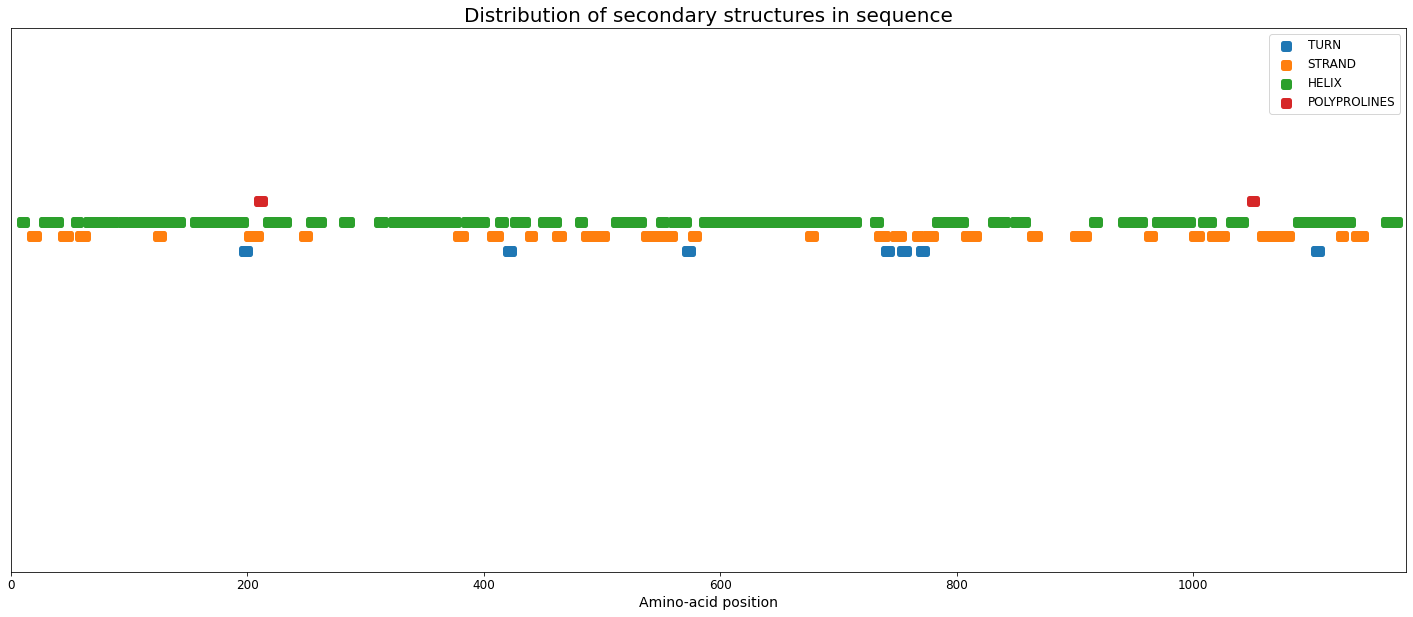

In [558]:
data, record = next(gen)
for feature in data:
    plt.axis((0, len(data), -0.5, 1.7))
    if feature == "POLYPROLINES":
        plot_data = data.loc[data[feature] > 0, feature]
        plt.scatter(plot_data.index, plot_data, lw=5, label=feature, marker="s")
    elif feature in {"HELIX", "TURN", "STRAND"}:
        plot_data = data.loc[data[feature] > 0, feature]
        plt.scatter(plot_data.index, plot_data, lw=5, label=feature, marker="s")
plt.xlabel("Amino-acid position", size=14)
plt.title("Distribution of secondary structures in sequence", size=20)
plt.yticks([], [])
plt.legend()
print(record.sequence)

## Distribution of polyproline motifs in sequence

This shows the most frequent locations of polyproline motifs in terms of complete sequence length.

In [416]:
motif_positions = []
for _, record in proline_feature_map_generator("uniprot-proteome_UP000000625.txt"):
    motif_positions.extend(list(map(lambda x: x / record.sequence_length, get_pp_motif_positions(record.sequence))))

Text(0, 0.5, 'Count')

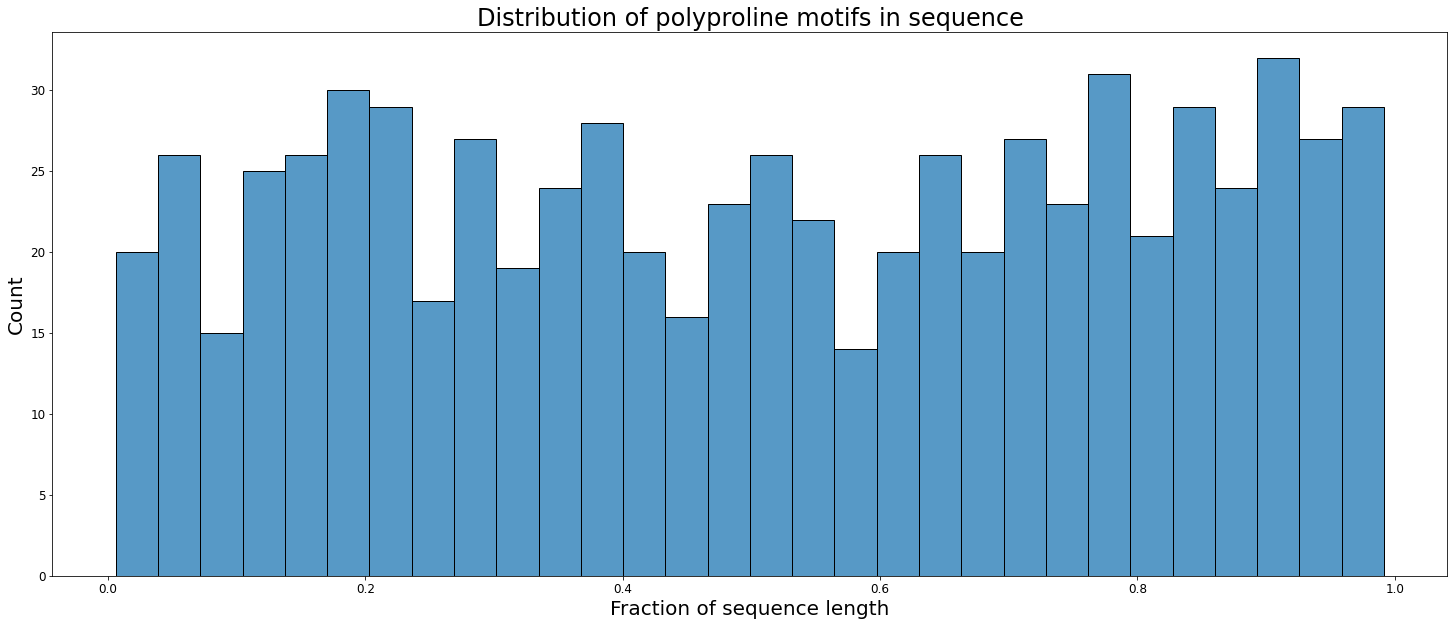

In [435]:
sns.histplot(motif_positions, bins=30)
plt.title("Distribution of polyproline motifs in sequence", size=24)
plt.xlabel("Fraction of sequence length", size=20)
plt.ylabel("Count", size=20)

## Do polyproline motifs overlap with secondary structures?

In [424]:
helix_overlaps = []
strand_overlaps = []
turn_overlaps = []
total_helix = []
total_strand = []
total_turn = []

for data, record in proline_feature_map_generator("uniprot-proteome_UP000000625.txt"):
    helix_overlaps.append(count_pp_seqs(polyproline_overlap_mask(data, "HELIX")))
    total_helix.append(len(list(filter(lambda x: x.type == "HELIX", record.features))))
    
    strand_overlaps.append(count_pp_seqs(polyproline_overlap_mask(data, "STRAND")))
    total_strand.append(len(list(filter(lambda x: x.type == "STRAND", record.features))))
    
    turn_overlaps.append(count_pp_seqs(polyproline_overlap_mask(data, "TURN")))
    total_turn.append(len(list(filter(lambda x: x.type == "TURN", record.features))))

In [430]:
print(f"{sum(helix_overlaps) / sum(total_helix) * 100:.2f}% of helices overlap with polyproline motifs")

1.84% of helices overlap with polyproline motifs


In [431]:
print(f"{sum(strand_overlaps) / sum(total_strand) * 100:.2f}% of strands overlap with polyproline motifs")

1.15% of strands overlap with polyproline motifs


In [432]:
print(f"{sum(turn_overlaps) / sum(total_turn) * 100:.2f}% of turns overlap with polyproline motifs")

6.14% of turns overlap with polyproline motifs


Text(0.5, 1.0, 'Distribution of polyproline motifs in helices')

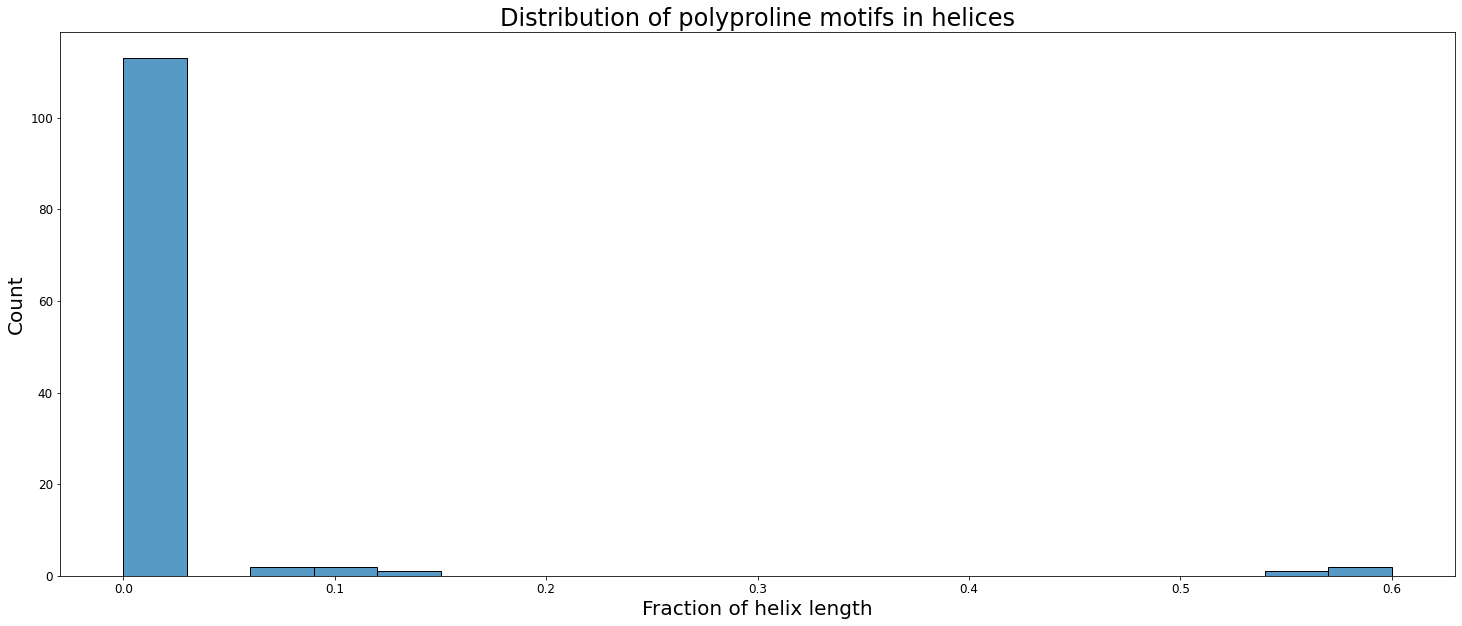

In [440]:
sns.histplot(motif_feature_positions, bins=20)
plt.xlabel("Fraction of helix length", size=20)
plt.ylabel("Count", size=20)
plt.title("Distribution of polyproline motifs in helices", size=24)

In [441]:
strand_motif_rel_positions = []
for feature_map, record in proline_feature_map_generator("uniprot-proteome_UP000000625.txt"):
    strand_motif_rel_positions += get_rel_pp_position(record, "STRAND")

Text(0.5, 1.0, 'Distribution of polyproline motifs in strands')

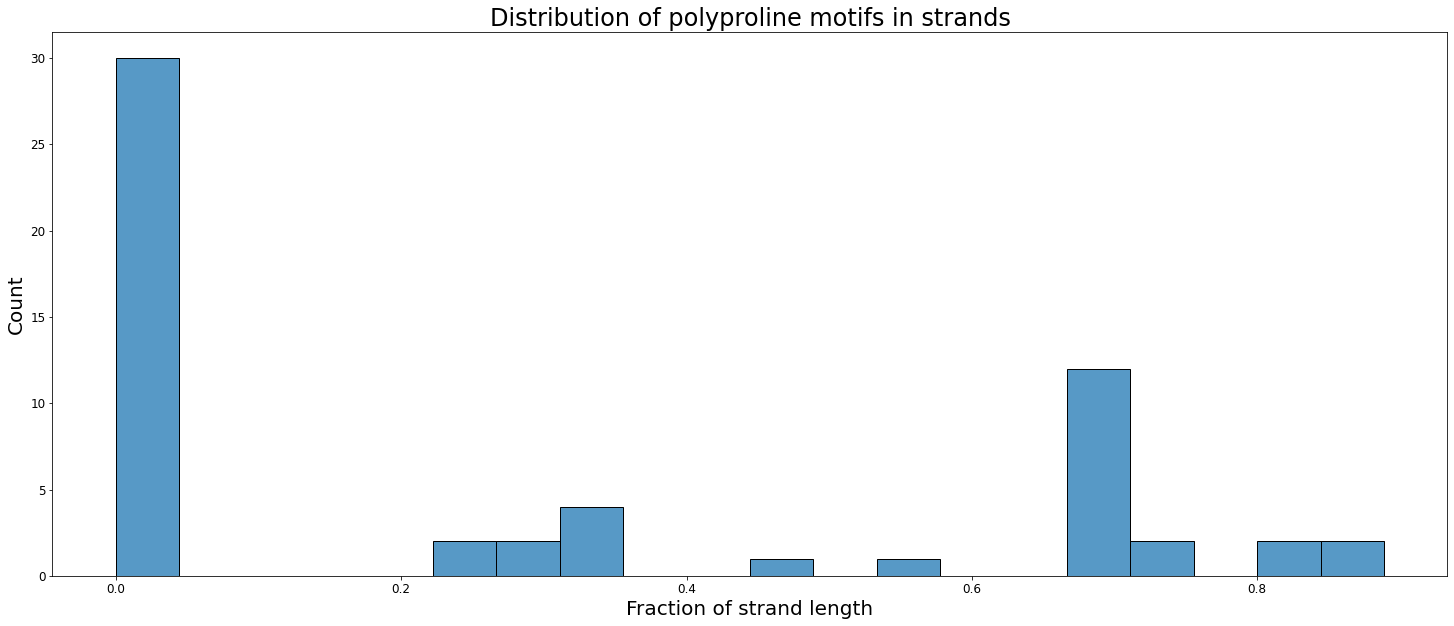

In [442]:
sns.histplot(strand_motif_rel_positions, bins=20)
plt.xlabel("Fraction of strand length", size=20)
plt.ylabel("Count", size=20)
plt.title("Distribution of polyproline motifs in strands", size=24)

In [443]:
turn_motif_rel_positions = []
for feature_map, record in proline_feature_map_generator("uniprot-proteome_UP000000625.txt"):
    turn_motif_rel_positions += get_rel_pp_position(record, "TURN")

Text(0.5, 1.0, 'Distribution of polyproline motifs in turns')

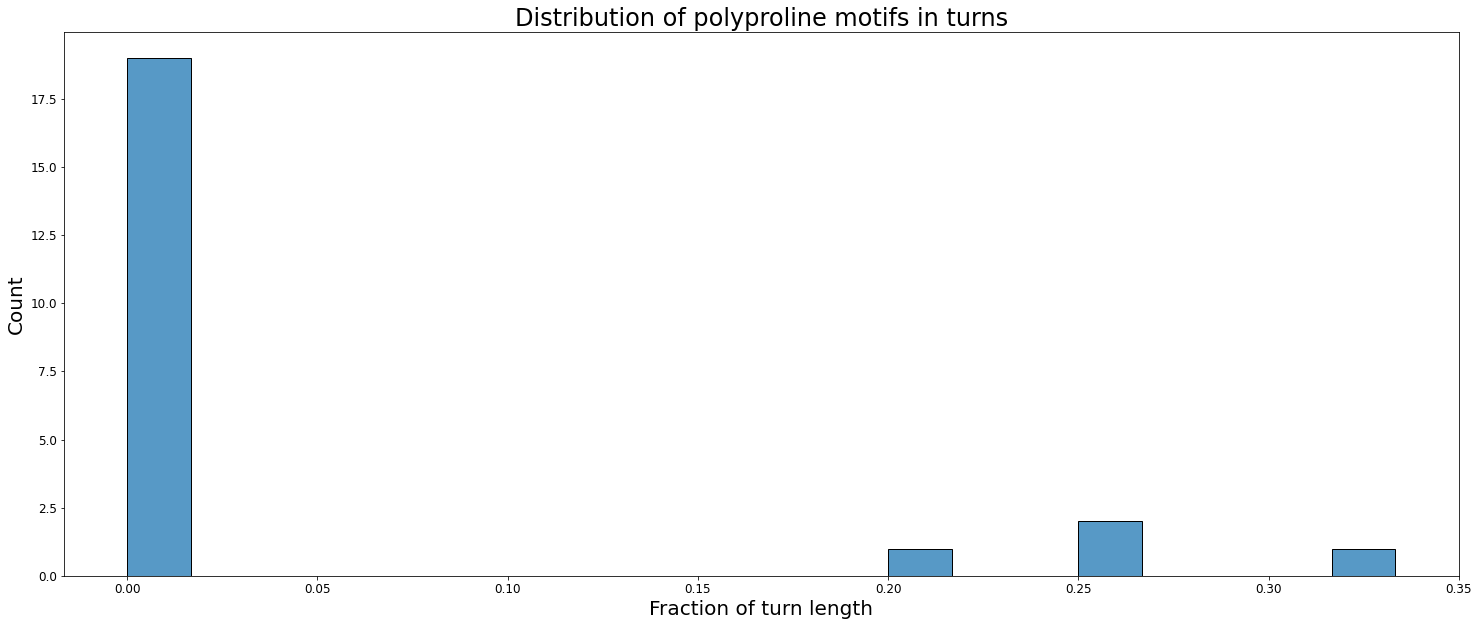

In [444]:
sns.histplot(turn_motif_rel_positions, bins=20)
plt.xlabel("Fraction of turn length", size=20)
plt.ylabel("Count", size=20)
plt.title("Distribution of polyproline motifs in turns", size=24)